<a href="https://colab.research.google.com/github/joeperry1/gwbursts/blob/main/FlowStrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Init

In [ ]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import math
import scipy as sp
import sys
from sys import getsizeof
from numpy.polynomial.chebyshev import Chebyshev as Cheb
from numpy.random import rand
from scipy.signal import tukey
import time
from google.colab import files
!pip install corner
import corner
import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

sns.set_context('talk')
sns.set_style('ticks')

!pip install nflows

     |████████████████████████████████| 51kB 6.8MB/s 
  Created wheel for nflows: filename=nflows-0.14-cp37-none-any.whl size=53672 sha256=d17e1ade5e9ed433db3211b7eed6169aae781b83488be412cf49937ce1240d0a
  Stored in directory: /root/.cache/pip/wheels/3d/88/9b/87a9884189f450092eb3bbe6a56bb23c17f4788ed3d5d5f7e4
Successfully built nflows


In [ ]:
import torch.nn.functional as F

from nflows.distributions import StandardNormal
from nflows import transforms
from nflows.nn.nets import ResidualNet
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms as T

In [ ]:
seed =  1234

np.random.seed(seed)
torch.random.manual_seed(seed)


##Define model

In [ ]:
class ImprovedRealNVP(torch.nn.Module):
    def __init__(self, 
                n_dims=None, 
                n_transforms=None,
                n_layers_per_transform=None,
                n_neurons_per_layer=None,
                n_conditional_inputs=None):
        super().__init__()

        # Define function for creating the neural network
        def create_net(in_features, out_features):
                return ResidualNet(
                    in_features,
                    out_features,
                    hidden_features=n_neurons_per_layer,
                    context_features=n_conditional_inputs,
                    num_blocks=n_layers_per_transform,
                    activation=F.leaky_relu,
                    dropout_probability=False,
                    use_batch_norm=True
                    )
        
        def create_linear_transform():
            return transforms.CompositeTransform([
                transforms.RandomPermutation(features=n_dims),
                transforms.LULinear(n_dims, identity_init=True,
                                    using_cache=False)
            ])

        # Make an alternating mask. If the value is one, the parameter is updated
        # if it <0 then it is used as the input to the NN
        mask = torch.ones(n_dims)
        mask[::2] = -1

        transforms_list = []
        for i in range(n_transforms):
            transforms_list.append(create_linear_transform())
            transform = transforms.AffineCouplingTransform(
                mask=mask, transform_net_create_fn=create_net
            )
            transforms_list.append(transforms.BatchNorm(features=n_dims))
            mask *= -1
            transforms_list.append(transform)

        self.transform = transforms.CompositeTransform(transforms_list)
        self.distribution = StandardNormal([n_dims])

    def forward(self, x, context=None):
        """
        Apply the forward transformation and return samples in the latent
        space and log |J|
        """
        return self.transform.forward(x, context=context)

    def inverse(self, z, context=None):
        """
        Apply the inverse transformation and return samples in the
        data space and log |J| (not log probability)
        """
        return self.transform.inverse(z, context=context)

    def log_prob(self, x, context=None):
        """
        Computes the log probability of the inputs samples by applying the
        transform.
        """
        z, logabsdet = self.transform(x, context=context)
        log_prob = self.distribution.log_prob(z)
        return log_prob + logabsdet

    def sample(self, n, context=None):
        """
        Produces N samples in the data space by drawing from the base
        distribution and the applying the inverse transform.
        """
        z = self.distribution.sample(n)
        samples, _ = self.transform.inverse(z, context=context)
        return samples

In [ ]:
# def one_hot(labels, class_size):
#     targets = torch.zeros(labels.size(0), class_size)
#     for i, label in enumerate(labels):
#         targets[i, label] = 1
#     return targets.to('cuda')

In [ ]:
flow = ImprovedRealNVP(88, 4, 4, 64, 256)
flow.to('cuda')
optimiser = torch.optim.Adam(flow.parameters(), lr=1e-3, weight_decay=1e-6)
# Configure training
n_epochs = 500
patience = 50
batch_size = 500

##MNIST

In [ ]:
digit1 = 1
digit2 = 5

In [ ]:
transform = T.Compose([
        T.ToTensor(),
        T.Normalize((0.1307,), (0.3081,)),
        T.Lambda(lambda x: torch.flatten(x))
        ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                    transform=transform)
idx = dataset1.targets==digit1
idx += dataset1.targets==digit2
dataset1.data = dataset1.data[idx]
dataset1.targets = dataset1.targets[idx]

idx = dataset2.targets==digit1
idx += dataset2.targets==digit2
dataset2.data = dataset2.data[idx]
dataset2.targets = dataset2.targets[idx]

train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

NameError: ignored

##Dynamics

In [ ]:
def DynGen(PolyOrder, sampling):
  xcoefs = np.zeros(PolyOrder)
  ycoefs = np.zeros(PolyOrder)
  zcoefs = np.zeros(PolyOrder)

  t = np.arange(-1,1,(2/sampling))

  for i in range(0,PolyOrder):
    #Generating coefficients from a uniform distribution in range [-1,1]
    xcoefs[i] = (2*rand())-1

  return xcoefs, t

In [ ]:
window = tukey(256)

def strain(total_dynamics):
  coefsq = np.polynomial.chebyshev.chebpow(total_dynamics, 2)
  sqrdif2 = np.polynomial.chebyshev.chebder(coefsq,2)
  
  return sqrdif2

In [ ]:
def dynweights(nummass):
  #Generating masses from a Dirichlet distribution
  masses = np.zeros(nummass)
  for n in range(0,nummass):
    masses[n] = np.random.rand()

  masses = masses/np.sum(masses)

  return masses

In [ ]:
def DataGen(ChebOrder, nummass, numsamples, samplerate = 256):
# ChebOrder - Order N of Chebyshev Polynomials T_N comprising series
# nummass - Number of masses
# numsamples - Number of Training Samples
# samplerate - Sampling rate (default 256 samples)

  hCoefs = np.zeros((numsamples, (ChebOrder*2)-3))
  #hLSQ = np.zeros((numsamples, 24))
  allweights = np.zeros((numsamples, nummass))
  FlattenedDynamics = np.zeros((numsamples, (nummass*ChebOrder)))
  flat_samples = np.zeros((numsamples, (nummass*ChebOrder)))
  h_tseries = np.zeros((numsamples, samplerate))
  h_tseries_noTukey = np.zeros((numsamples, samplerate))
  h_tseries_unscaled = np.zeros((numsamples, samplerate))

  for sample in range(0,numsamples):

    overall_dynamics = np.zeros(ChebOrder)
    overall_strain = np.zeros((ChebOrder*2)-3)
    weights = dynweights(nummass)
    allweights[sample, :] = weights

    for mass in range(0,nummass):

      b, sampling_points = DynGen(ChebOrder, samplerate)
      FlattenedDynamics[sample, (len(b)*mass):(len(b)*(mass + 1))] = b
      b_strain = strain(b)
      overall_strain = np.add(overall_strain,weights[mass]*b_strain)
      overall_dynamics = np.add(overall_dynamics,(weights[mass]*np.array(b)))

    hCoefs[sample, :] = strain(overall_dynamics)
    # hCoefs[sample, :] = overall_strain

    #Producing strain timeseries from coefficients of strain
    h_tseries_noTukey[sample, :] = np.polynomial.chebyshev.chebval(sampling_points, hCoefs[sample, :])
    h_tseries[sample, :] = window * np.polynomial.chebyshev.chebval(sampling_points, hCoefs[sample, :])
    #experiment
    #hLSQ[sample, :] = np.polynomial.chebyshev.chebfit(sampling_points, h_tseries[sample, :], 23)

  h_tseries_unscaled = h_tseries
  h_tseries = (2*((h_tseries - np.min(h_tseries))/(np.max(h_tseries) - np.min(h_tseries))))-1
  #h_tseries = ((h_tseries - np.min(h_tseries))/(np.max(h_tseries) - np.min(h_tseries)))
  #flat_dyn_tseries = ((flat_dyn_tseries - np.min(flat_dyn_tseries))/(np.max(flat_dyn_tseries) - np.min(flat_dyn_tseries)))
  #experiment
  #hLSQnorm = (2*((hLSQ - np.min(hLSQ))/(np.max(hLSQ) - np.min(hLSQ))))-1
  
  # FlattenedDynamics = (FlattenedDynamics + 1)/2
  # FlattenedDynamics = (2*((FlattenedDynamics - np.min(FlattenedDynamics))/(np.max(FlattenedDynamics) - np.min(FlattenedDynamics))))-1
  flat_samples = np.concatenate((FlattenedDynamics, allweights), axis=1)
  #flat_samples_tseries = np.concatenate((flat_dyn_tseries, allweights), axis=1)

  return allweights, sampling_points, h_tseries, flat_samples, h_tseries_unscaled, h_tseries_noTukey #, flat_samples_tseries

In [ ]:
start_time = time.time()
totalSamples = 100000
massnum = 8
Order = 10

curveweights, sample_len, HTseries, flat_samples, HTseries_unscaled, HTseries_unwindowed = DataGen(Order, massnum, totalSamples)

elapsed_time = time.time() - start_time

print(elapsed_time)

138.54241037368774


In [ ]:
samples_tensor = torch.Tensor(flat_samples)
tensor_strain = torch.Tensor(HTseries)

my_dataset = TensorDataset(samples_tensor, tensor_strain)
a = int(0.9*len(my_dataset))
b = len(my_dataset) - a

train_set, val_set = random_split(my_dataset, (a, b))
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

##Train

In [ ]:
%%time
# Variables for checkpointing
best_epoch = 0
best_val_loss = np.inf
best_model = copy.deepcopy(flow.state_dict())

# Loss
loss_dict = dict(train=[], val=[])

for n in range(n_epochs):
    
    # Train
    train_loss = 0
    flow.train()
    for batch_num,(x_tensor, labels) in enumerate(train_loader):
        x_tensor, labels = x_tensor.to('cuda'), labels.to('cuda')
        # labels = one_hot(labels, 10)
        optimiser.zero_grad()
        loss = -flow.log_prob(x_tensor, context=labels).mean()
        loss.backward()
        optimiser.step()
        train_loss += loss.cpu().detach().numpy()
    train_loss /= len(train_loader)
    loss_dict['train'].append(train_loss)
    
    # Validate
    val_loss = 0
    with torch.no_grad():
        flow.eval()
        for batch_num,(x_tensor, labels) in enumerate(test_loader):
            x_tensor, labels = x_tensor.to('cuda'), labels.to('cuda')
            # labels = one_hot(labels, 10)
            val_loss += -flow.log_prob(x_tensor, context=labels).mean().cpu().numpy()
    val_loss /= len(test_loader)

    loss_dict['val'].append(val_loss)

    # Save the best model for use at the end
    if val_loss < best_val_loss:
        best_epoch = n
        best_val_loss = val_loss
        best_model = copy.deepcopy(flow.state_dict())
        
    # Print loss every n epochs
    if not n % 5:
        print(f'{n}: Train loss: {train_loss:1.4f}')
        print(f'{n}: Val loss: {val_loss:1.4f}')
        
    # Early stopping
    if n - best_epoch > patience:
        print('Reached patience')
        break

# Load the best model
print('Finished training')
print(f'Best epoch: {best_epoch}')
print(f'Epoch {best_epoch} val loss: {best_val_loss:1.4f}')
print('Loading best model')
flow.load_state_dict(best_model)
flow.eval()

##Loss Plots

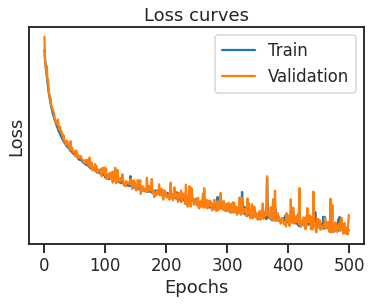

In [ ]:
plt.plot(loss_dict['train'], label='Train')
plt.plot(loss_dict['val'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss curves')
plt.yscale('symlog')
plt.show()

In [ ]:
with torch.no_grad():
    zarray = np.zeros((batch_size*len(test_loader), 11*massnum))
    for i in range(0, len(test_loader)):
      x, c = next(iter(test_loader))

      z, _ = flow.forward(x.to('cuda'), c.to('cuda'))
      z = z.cpu().numpy()
      zarray[i*500:(i+1)*500,:] = z
    m = 3
    var = []
    for i in range(massnum*11):
      var = var + [[-m,m]]
    figure = corner.corner(zarray, color='tab:red', range=(var))

##Sample Generation

In [ ]:
with torch.no_grad():
    x, c = next(iter(test_loader))

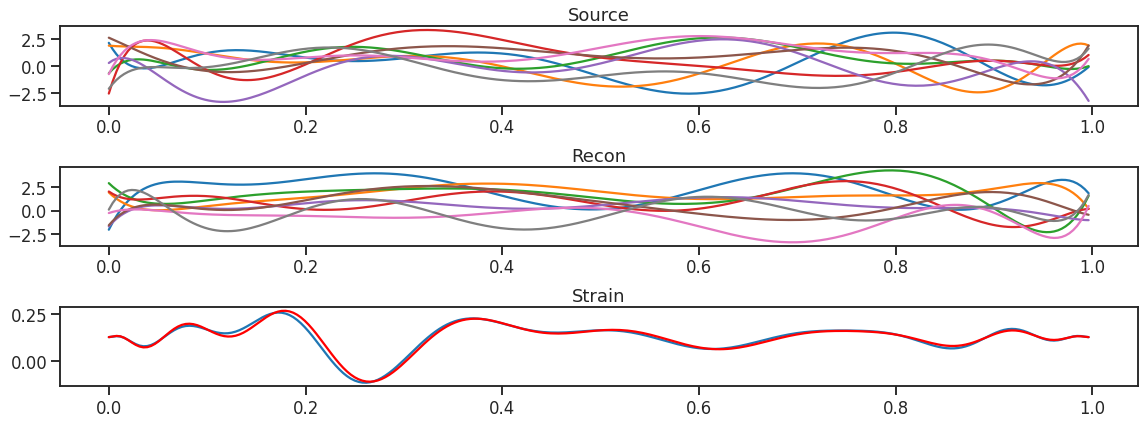

In [ ]:
with torch.no_grad():
    x = x[0].unsqueeze(0) #.to('cuda').unsqueeze(0)
    c = c[0] #.to('cuda').unsqueeze(0)
    x_out = flow.sample(1, c.unsqueeze(0).to('cuda')).cpu().numpy()
    source = x.detach().cpu().numpy().squeeze()
    # print(source)
    source_dyn = source[0:(len(source)-massnum)]
    source_dyn_unflattened = source_dyn.reshape((massnum, Order))
    recon = x_out.squeeze()
    # print(recon)
    # print(recon.shape)
    recon_dyn = recon[0:(len(recon)-massnum)]
    recon_dyn_unflattened = recon_dyn.reshape((massnum, Order))
    t = np.arange(-1,1,(2/256))
    t_shifted = np.arange(0,1,(1/256))
    c = c.cpu().squeeze()
    recon_summed_dyn = np.zeros(Order)
    source_summed_dyn = np.zeros(Order)
    recon_weights = recon[(len(recon)-massnum):len(recon)]
    # print(recon_weights)
    source_weights = source[(len(source)-massnum):len(source)]
    overall_recon_strain = np.zeros((Order*2)-3)

    size = (16,6)
    fig, axes = plt.subplots(3, 1, figsize=size)

    for mass in range(0, massnum):
      source_tseries = np.polynomial.chebyshev.chebval(t, source_dyn_unflattened[mass, :])
      recon_tseries = np.polynomial.chebyshev.chebval(t, recon_dyn_unflattened[mass, :])
      axes[0].plot(t_shifted, source_tseries, label=mass)#, color='r')
      axes[1].plot(t_shifted, recon_tseries, label=mass)
      recon_summed_dyn += (recon_dyn_unflattened[mass, :] * recon_weights[mass])
      # source_summed_dyn += (source_dyn_unflattened[mass, :] * source_weights[mass])
      # recon_strain = strain(recon_dyn_unflattened[mass, :])
      # overall_recon_strain = np.add(overall_recon_strain,recon_weights[mass]*recon_strain)

    # print(overall_recon_strain)
    recon_coefsq = np.polynomial.chebyshev.chebpow(recon_summed_dyn, 2)
    recon_hcoefs = np.polynomial.chebyshev.chebder(recon_coefsq,2)
    recon_htseries = window * np.polynomial.chebyshev.chebval(t, recon_hcoefs)

    # recon_htseries = window * np.polynomial.chebyshev.chebval(t, overall_recon_strain)
    recon_htseries = (2*((recon_htseries - np.min(HTseries_unscaled))/(np.max(HTseries_unscaled) - np.min(HTseries_unscaled))))-1

    axes[0].set_title("Source")
    axes[1].set_title("Recon")
    axes[2].set_title("Strain")
    axes[2].plot(t_shifted, recon_htseries)
    axes[2].plot(t_shifted, c, color='r')

    # axes.plot(t_shifted, HTseries_unwindowed[2]/1000, color='r')

#plt.xticks([])
#plt.yticks([])
# axes.set_xticks(np.arange(0,1.01,0.1))
# axes.tick_params(axis='both', which='major', labelsize=20)
# axes.grid(b=bool)
# axes.set_xlabel('Time (s)', fontsize=20)
# axes.set_ylabel('Position', fontsize=20)

#labels = ['']
#axes.set_xticklabel('Time (s)')
#print(np.max(t_shifted))
# axes.set_xlim([0, 1])
# axes[1].set_xlim([0, 1])
# axes[2].set_xlim([0, 1])
fig.subplots_adjust()
fig.tight_layout()
#fig.legend()
plt.show()
c = c.unsqueeze(0)

In [ ]:
c = c.unsqueeze(0)

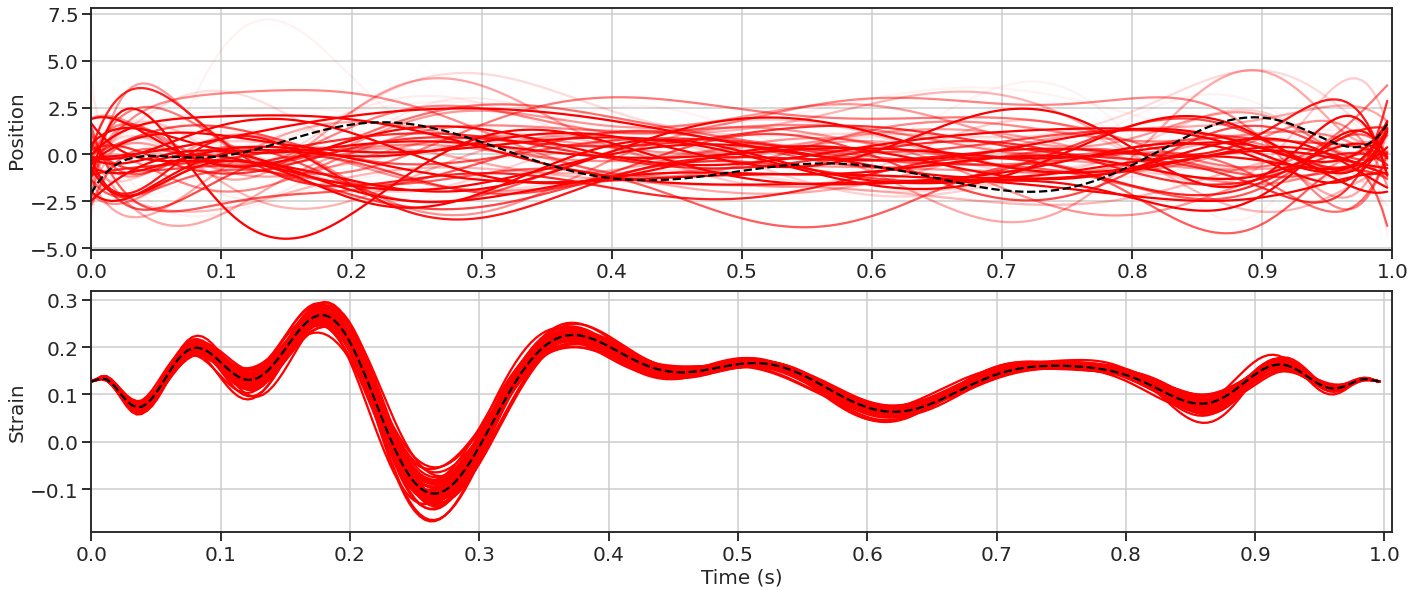

In [ ]:
from matplotlib.lines import Line2D
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(19,8))
source_tseries_array = np.zeros((8,256))
t_shifted = np.arange(0,1,(1/256))
plt.setp(axes, xlim=(0,np.max(t_shifted+0.01)))#, ylim=(-5.8,5.8))
#ax.tick_params(axis='both', which='major', labelsize=5)
#ax.tick_params(axis='both', which='minor', labelsize=5)



with torch.no_grad():
    for j in range (0,50):
      recon_summed_dyn = np.zeros(Order)
      x_out = flow.sample(1, c.to('cuda')).cpu().numpy()
      recon = x_out.squeeze()
      recon_dyn = recon[0:(len(recon)-massnum)]
      recon_unflattened_dyn = recon_dyn.reshape((massnum, Order))
      recon_weights = recon[(len(recon)-massnum):len(recon)]
      recon_weights_rescaled = (0.95*((recon_weights - np.min(recon_weights))/(np.max(recon_weights) - np.min(recon_weights))))+0.05
      source_weights_rescaled = (0.95*((source_weights - np.min(source_weights))/(np.max(source_weights) - np.min(source_weights))))+0.05
      for mass in range(0, 8):
        #Use random latent space point z to produce multiple possible dynamics for a single strain
        recon_tseries = np.polynomial.chebyshev.chebval(t, recon_unflattened_dyn[mass, :])
        # if j == 0:
          #axes[mass].set_title(f"Mass {mass+1}")
        if mass == 0:
          axes[mass].plot(t_shifted, recon_tseries, color='r', alpha = recon_weights_rescaled[mass])
          axes[mass].set_xlim([0, np.max(t_shifted)])
        recon_summed_dyn += (recon_unflattened_dyn[mass, :] * recon_weights[mass])

      x_coefsq = np.polynomial.chebyshev.chebpow(recon_summed_dyn, 2)
      x_hcoefs = np.polynomial.chebyshev.chebder(x_coefsq,2)
      recon_htseries = window * np.polynomial.chebyshev.chebval(t, x_hcoefs)
      recon_htseries = (2*((recon_htseries - np.min(HTseries_unscaled))/(np.max(HTseries_unscaled) - np.min(HTseries_unscaled))))-1
        
      axes[1].plot(t_shifted, recon_htseries, 'r')
    axes[1].plot(t_shifted, c.squeeze(), color='k', ls='--')
    # axes[0].set_title("Strain")

    for mass in range(0, 8):
      source_tseries_array[mass,:] = np.polynomial.chebyshev.chebval(t, source_dyn_unflattened[mass, :])
      source_tseries = np.polynomial.chebyshev.chebval(t, source_dyn_unflattened[mass, :])
    axes[0].plot(t_shifted, source_tseries, 'k--')
      # axes[mass].xaxis.set_tick_params(labelsize=1)

    
    # custom_lines = [Line2D([0], [0], color='k', lw=4, linestyle='--'),
                # Line2D([0], [0], color='r', lw=4)]
    # custom_labels = ['Source', 'Reconstruction']
    #plt.legend(custom_lines, custom_labels)#, bbox_to_anchor=(1.04,1), loc="upper left")
    fig.subplots_adjust()
    fig.tight_layout()
    axes[0].set_xticks(np.arange(0,1.01,0.1))
    axes[1].set_xticks(np.arange(0,1.01,0.1))
    axes[0].tick_params(axis='both', which='major', labelsize=20)
    axes[1].tick_params(axis='both', which='major', labelsize=20)
    axes[0].grid(b=bool)
    axes[1].grid(b=bool)
    # axes[0].set_xlabel('Time (s)', fontsize=20)
    axes[1].set_xlabel('Time (s)', fontsize=20)
    axes[0].set_ylabel('Position', fontsize=20)
    axes[1].set_ylabel('Strain', fontsize=20)
    plt.show()

In [ ]:
%%time

t = np.arange(-1,1,(2/256))
MRMSEList = np.zeros(1000)
num_realisations = 50

#Histogram
with torch.no_grad():
  for i in range(0,2):
    x, c = next(iter(test_loader))
    for j in range(0,batch_size):
      RMSEList = np.zeros(num_realisations)
      for k in range(0,num_realisations):
        x_out = flow.sample(1, c[j].unsqueeze(0).to('cuda')).cpu().numpy()
        recon = x_out.squeeze()
        recon_dyn = recon[0:(len(recon)-massnum)]
        recon_weights = recon[(len(recon)-massnum):len(recon)]
        recon_dyn_unflattened = recon_dyn.reshape((massnum, Order))
        recon_summed_dyn = np.zeros(Order)
        c = c.cpu().squeeze()
        for mass in range(0, massnum):
          recon_summed_dyn += (recon_dyn_unflattened[mass, :] * recon_weights[mass])

        recon_coefsq = np.polynomial.chebyshev.chebpow(recon_summed_dyn, 2)
        recon_hcoefs = np.polynomial.chebyshev.chebder(recon_coefsq,2)
        recon_htseries = window * np.polynomial.chebyshev.chebval(t, recon_hcoefs)
        recon_htseries = (2*((recon_htseries - np.min(HTseries_unscaled))/(np.max(HTseries_unscaled) - np.min(HTseries_unscaled))))-1

        total_SE = 0
        for l in range(0,256):
          SE = (c[j,l]-recon_htseries[l])**2
          total_SE = total_SE + SE

        MSE = total_SE/256
        RMSEList[k] = np.sqrt(MSE)
      MRMSE = np.sum(RMSEList)/num_realisations
      MRMSEList[(i*500)+j] = MRMSE

CPU times: user 58min 18s, sys: 1min 34s, total: 59min 53s
Wall time: 59min 42s
Parser   : 111 ms


In [ ]:
#Saving the file

filename = f"MeanRMSE_Flow_1k_50"
with open(filename, 'wb+') as f:
  np.savez(f, MRMSEList)

In [ ]:
files.download('MeanRMSE_Flow_1k_50.npz')

In [ ]:
files.download('MeanRMSE_Flow_1k_50')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(MRMSEList)

In [ ]:
with np.load("MeanRMSE_CVAE_50 (1)") as CVAE_RMSE:
  MRMSE_List_CVAE = CVAE_RMSE['CVAE_MRMSE_List']

with np.load("MeanRMSE_Flow_1k_50") as Flow_RMSE:
  MRMSE_List_Flow = Flow_RMSE['arr_0']

In [ ]:
print(np.mean(MRMSE_List_Flow))

39784.173935762316


In [ ]:
print(np.mean(MRMSE_List_CVAE))

0.038048717818801384


In [ ]:
print(MRMSE_List_Flow)

In [ ]:
print(np.max(MRMSE_List_Flow))

39661030.441374205


In [ ]:
print(np.where(a == 123131.28444735231))

(array([676]),)


In [ ]:
a = np.delete(a, 676)

In [ ]:
print(np.mean(a))
print(np.std(a))

print(np.mean(MRMSE_List_CVAE))
print(np.std(MRMSE_List_CVAE))

0.012234409569934355
0.0065405723455046645
0.038048717818801384
0.02317457088053716


In [ ]:
print(np.mean())

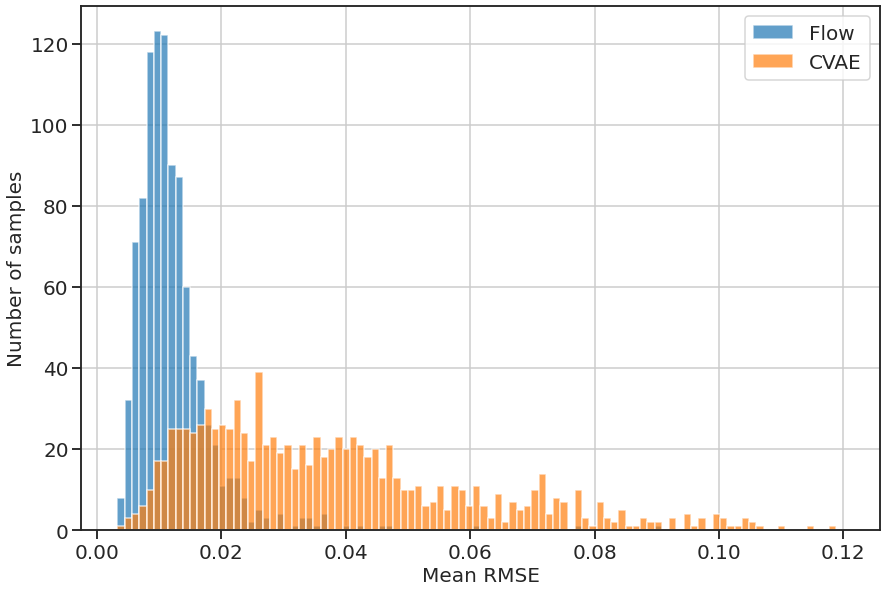

CPU times: user 608 ms, sys: 115 ms, total: 723 ms
Wall time: 606 ms


In [ ]:
%%time

plt.figure(figsize=((12,8)))
# plt.hist((MRMSE_List_Flow,MRMSE_List_CVAE), 60, range=(np.min(MRMSE_List_Flow), 1e-1))

plt.hist(MRMSE_List_Flow, 100, range=(np.min(MRMSE_List_Flow), 1.2e-1), alpha=0.7, label='Flow')
plt.hist(MRMSE_List_CVAE, 100, range=(np.min(MRMSE_List_Flow), 1.2e-1), alpha=0.7, label='CVAE')
plt.tight_layout()

#     axes[0].set_xticks(np.arange(0,1.01,0.1))
#     axes[1].set_xticks(np.arange(0,1.01,0.1))
plt.tick_params(axis='both', which='major', labelsize=20)
# plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(b=bool)
plt.xlabel('Mean RMSE', fontsize=20)
plt.ylabel('Number of samples', fontsize=20)
#     axes[1].set_xlabel('Time (s)', fontsize=20)
# axes[0].set_ylabel('Position', fontsize=20)
# axes[1].set_ylabel('Strain', fontsize=20)
plt.legend(fontsize=20)
plt.show()

In [ ]:
print(np.max(MRMSEList))

39661030.441374205


##Animation

In [ ]:
%matplotlib inline

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML

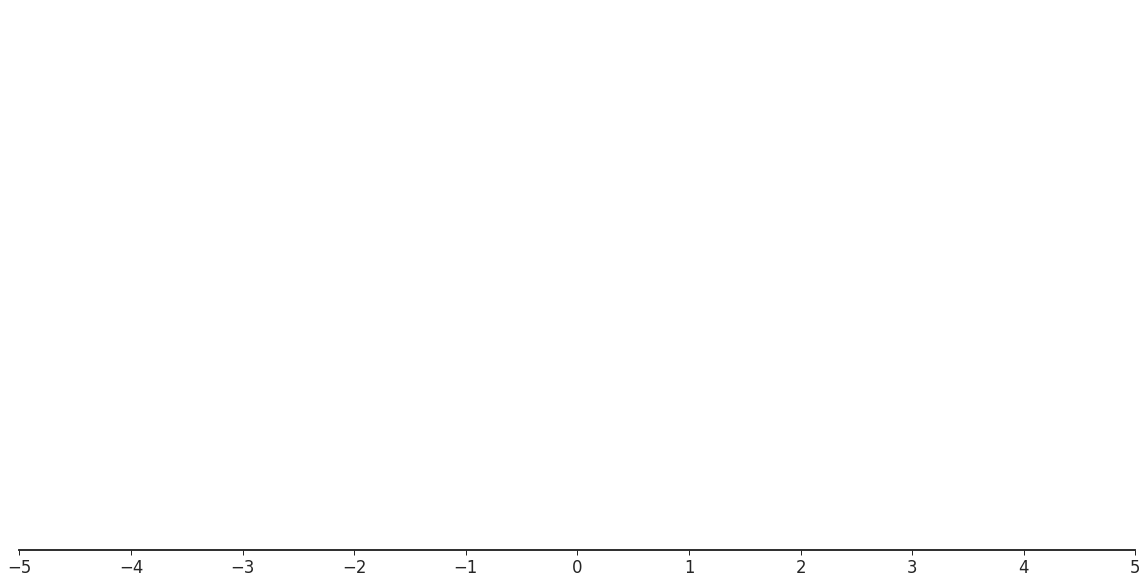

In [ ]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(20,10))

ax.spines['right'].set_color('none')
ax.spines['left'].set_color('none')
ax.yaxis.set_major_locator(ticker.NullLocator())
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(which='major', width=1.00)
ax.tick_params(which='major', length=5)
ax.tick_params(which='minor', width=0.75)
ax.tick_params(which='minor', length=2.5)
ax.set_xlim(-5,5)
ax.set_ylim(0,1)
ax.patch.set_alpha(0.0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.NullLocator())
plt.gca()
ax.set_facecolor((0.5, 0.5, 0.5))
scat = ax.scatter([[]],[[]], cmap='hsv', alpha=0.6)


In [ ]:
#source_tseries_array

def init():
    scat = ax.scatter([[]],[[]],cmap='hsv', alpha=0.6)
    return scat,


In [ ]:
def animate(i):
  scat.set_offsets(np.vstack((source_tseries_array[:, i], [0.07]*8)).T)
  scat.set_sizes(source_weights * 20000)
  scat.set_array(np.arange(8))
  return scat,

In [ ]:
# call the animator. blit=True means only re-draw the parts that have changed
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=256, interval=40)

In [ ]:
HTML(anim.to_html5_video())